# Problem Statement

Fradulent Medicare claims is a serious problem impacting the healthcare industry. The purpose of this project is to build a predictive model to detect such claims and help insurance companies to act on those.

# Project Structure

- Data Understading
- Data Prepration
- Exploratory Data Analysis & Feature Engineering
- Modelling
- Model Evaluation
- Deployment

# Data Understanding

As a first step, all sample files will be imported into data frames and preliminary analysis is done.

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

sns.set(rc={"figure.figsize":(10, 5)})

In [208]:
file_path="./fraud_data"
in_patient=f"{file_path}/Train_Inpatientdata-1542865627584.csv"
out_patient=f"{file_path}/Train_Outpatientdata-1542865627584.csv"
bene=f"{file_path}/Train_Beneficiarydata-1542865627584.csv"
labelled=f"{file_path}/Train-1542865627584.csv"

In [209]:
df_in = pd.read_csv(in_patient)
df_out = pd.read_csv(out_patient)
df_bene = pd.read_csv(bene)
df_lab = pd.read_csv(labelled)

# Data Preparation

## **Labelled data**

In [210]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

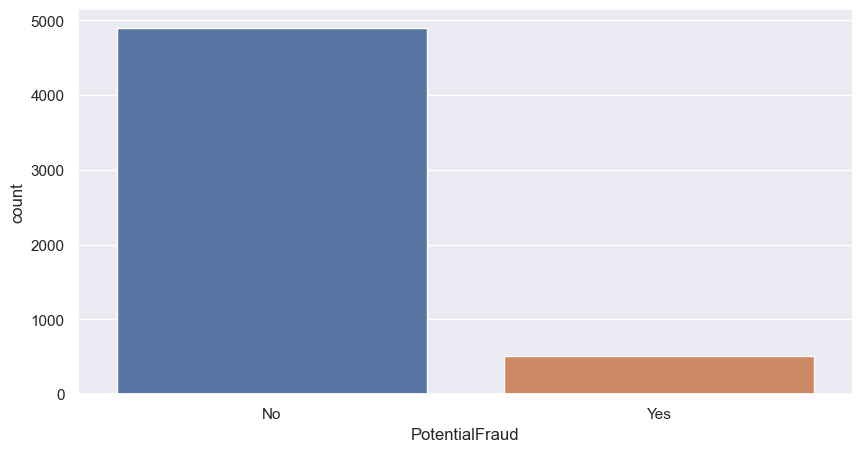

In [211]:
sns.countplot(x='PotentialFraud', data=df_lab)

## **Inpatient data**

**Convert datatypes**

In [212]:
df_in['ClaimStartDt'] = pd.to_datetime(df_in['ClaimStartDt'], infer_datetime_format=True)
df_in['ClaimEndDt'] = pd.to_datetime(df_in['ClaimEndDt'], infer_datetime_format=True)
df_in['claim_duration'] = (df_in['ClaimEndDt'] - df_in['ClaimStartDt']).dt.days

df_in['AdmissionDt']  = pd.to_datetime(df_in['AdmissionDt'], infer_datetime_format=True)
df_in['DischargeDt']  = pd.to_datetime(df_in['DischargeDt'], infer_datetime_format=True)
df_in['hospital_duration'] = (df_in.DischargeDt - df_in.AdmissionDt).dt.days

In [213]:
df_in['AttendingPhysician'] = df_in['AttendingPhysician'].fillna("None")
df_in['OperatingPhysician'] = df_in['OperatingPhysician'].fillna("None")
df_in['OtherPhysician'] = df_in['OtherPhysician'].fillna("None")

In [214]:
# df_in['AttendingPhysician'] = df_in['AttendingPhysician'].astype(pd.StringDtype())

# not-working
for col in df_in.columns: 
    if df_in[col].dtype == 'object':
        df_in[col] = df_in[col].astype('str')

In [215]:
df_in_corr = df_in.loc[:, ['InscClaimAmtReimbursed',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4','ClmProcedureCode_5']
                             ].corr()
df_in_corr = round(df_in_corr.corr(), 2)

In [216]:
# sns.heatmap(df_in_corr, annot=True)

**Merge labelled data with inpatient data**

In [217]:
df_in = df_in.merge(df_lab, how='left', left_on='Provider', right_on='Provider')

In [218]:
df_in.PotentialFraud.value_counts()

Yes    23402
No     17072
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

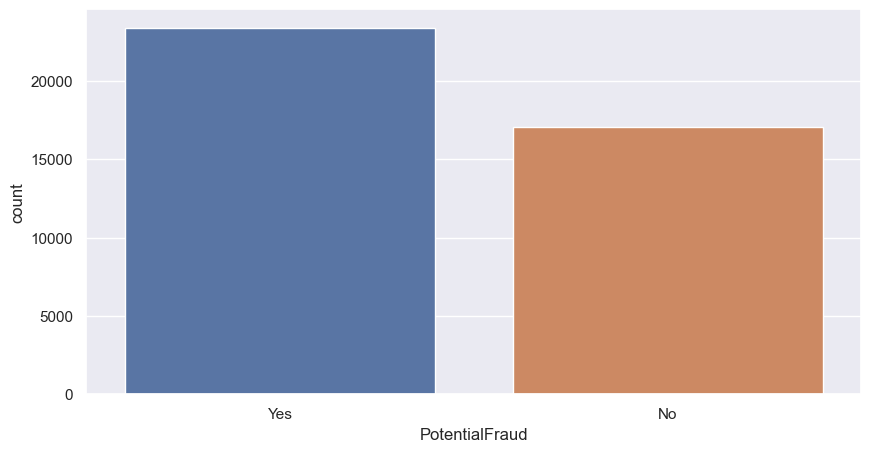

In [219]:
sns.countplot(x='PotentialFraud', data=df_in)

<AxesSubplot:>

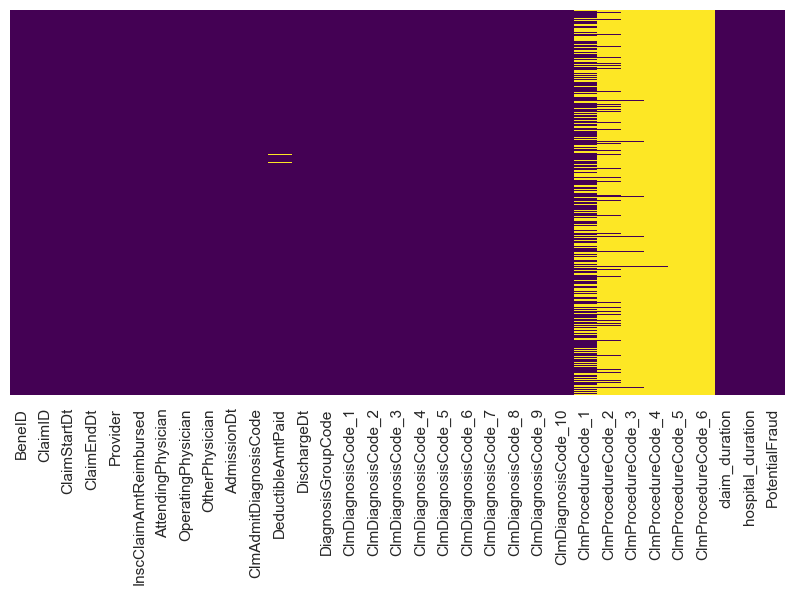

In [220]:
sns.heatmap(df_in.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**Create provider bins**

In [221]:
tmp = df_in.groupby(['Provider']).size()
tmp.name = 'Provcnt'

In [222]:
df_in_new = pd.merge(df_in, tmp, left_on = 'Provider', right_index=True)

In [223]:
bins = pd.cut(df_in_new.Provcnt, bins=4, labels=['low', 'med', 'high', 'top'])

In [224]:
bins.value_counts()

low     31732
med      6961
high     1265
top       516
Name: Provcnt, dtype: int64

## **Outpatient data**

In [225]:
df_out['ClaimStartDt'] = pd.to_datetime(df_out['ClaimStartDt'], infer_datetime_format=True)
df_out['ClaimEndDt'] = pd.to_datetime(df_out['ClaimEndDt'], infer_datetime_format=True)
df_out['claim_duration'] = (df_out['ClaimEndDt'] - df_out['ClaimStartDt']).dt.days
df_out['hospital_duration'] = 0

**Merge labelled data with outpatient data**

In [226]:
df_out = df_out.merge(df_lab, how='left', left_on='Provider', right_on='Provider')

In [227]:
df_out.PotentialFraud.value_counts()

No     328343
Yes    189394
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

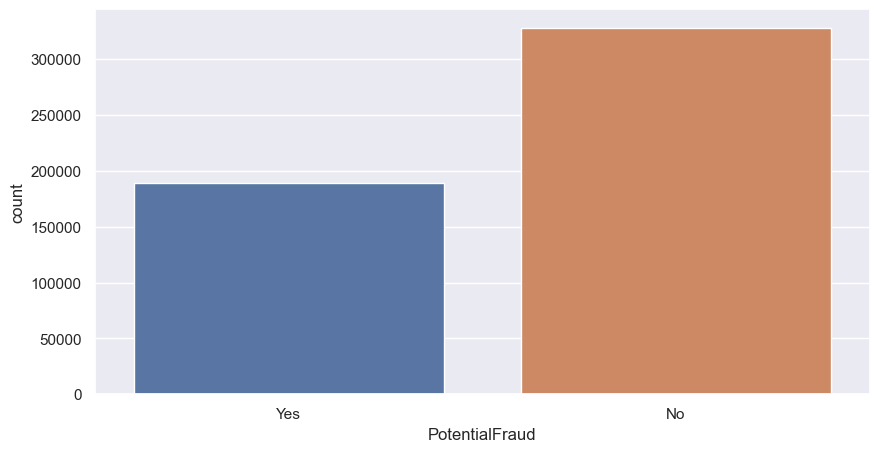

In [228]:
sns.countplot(x='PotentialFraud', data=df_out)

In [229]:
df_out_corr = df_out.loc[:, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                              'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
                              'ClmProcedureCode_4']
                             ].corr()
# df_out_corr = round(df_out_corr, 2)

In [230]:
# sns.heatmap(df_out_corr, annot=True)

In [231]:
df_out['AttendingPhysician'] = df_out['AttendingPhysician'].fillna("None")
df_out['OperatingPhysician'] = df_out['OperatingPhysician'].fillna("None")
df_out['OtherPhysician'] = df_out['OtherPhysician'].fillna("None")

<AxesSubplot:>

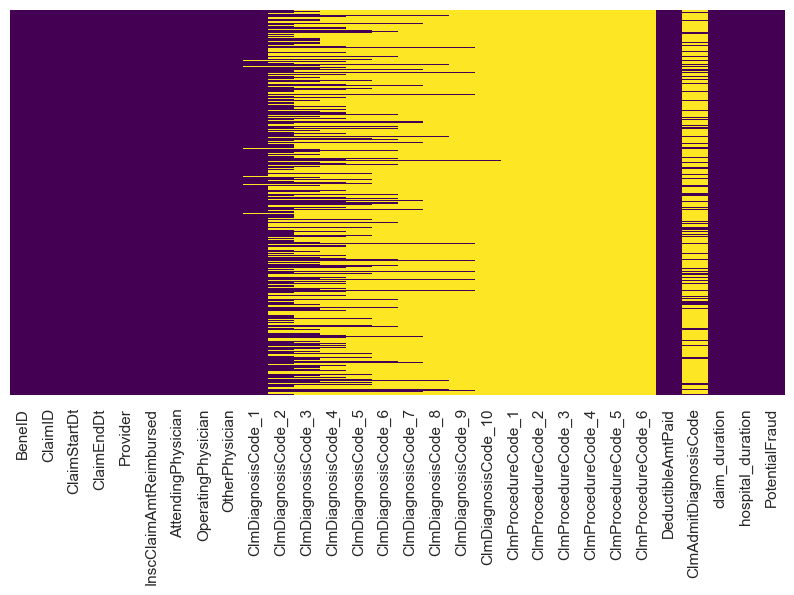

In [232]:
sns.heatmap(df_out.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## **Beneficiary data**

<AxesSubplot:>

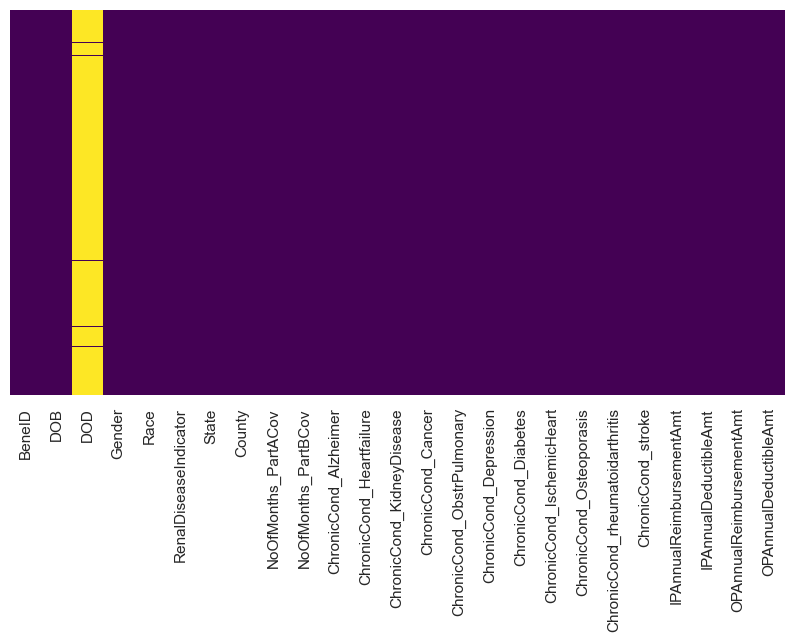

In [233]:
sns.heatmap(df_bene.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [234]:
df_bene['DOB'] = pd.to_datetime(df_bene['DOB'], format = '%Y-%m-%d')
df_bene['DOD'] = pd.to_datetime(df_bene['DOD'], format = '%Y-%m-%d')

***Age***

The max DOD date is 2009-01-12. This is used to fillin NaN values to cacluate age of beneficiary.

In [235]:
df_bene['DOD'].fillna("2009-12-01", inplace=True)
df_bene['Age'] = df_bene['DOD'].dt.year - df_bene['DOB'].dt.year

In [236]:
# sns.heatmap(df_bene_corr, annot=True)

In [237]:
bene_age_tier = [
    (df_bene['Age'] <= 30),
    (df_bene['Age'] > 30) & (df_bene['Age'] <= 45),
    (df_bene['Age'] > 45) & (df_bene['Age'] <= 64),
    (df_bene['Age'] >= 65)
    ]

In [238]:
bene_age = df_bene['Age']
bene_age = np.select(bene_age_tier, ['Young', 'Early middle' ,'Late middle', 'Senior'])

<AxesSubplot:ylabel='count'>

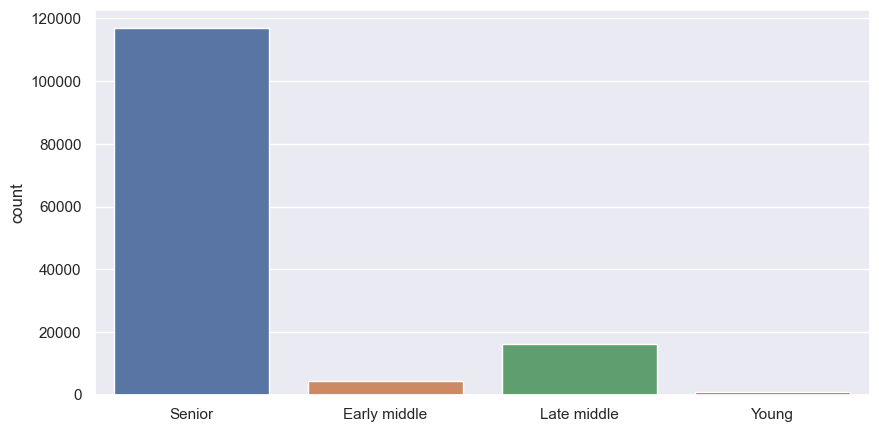

In [239]:
sns.countplot(x=bene_age)
#sns.countplot(x='Age', data=df_bene)

**Bene claimed as inpatient or outpatient**

In [240]:
df_bene['has_claimed_ip'] = df_bene['BeneID'].isin(df_in['BeneID'])
df_bene['has_claimed_op'] = df_bene['BeneID'].isin(df_out['BeneID'])

<AxesSubplot:xlabel='has_claimed_ip', ylabel='count'>

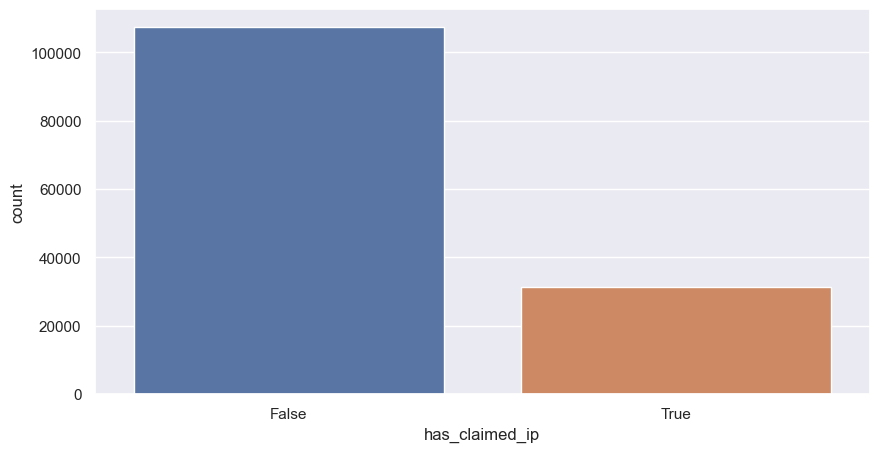

In [241]:
sns.countplot(x='has_claimed_ip', data=df_bene)

<AxesSubplot:xlabel='has_claimed_op', ylabel='count'>

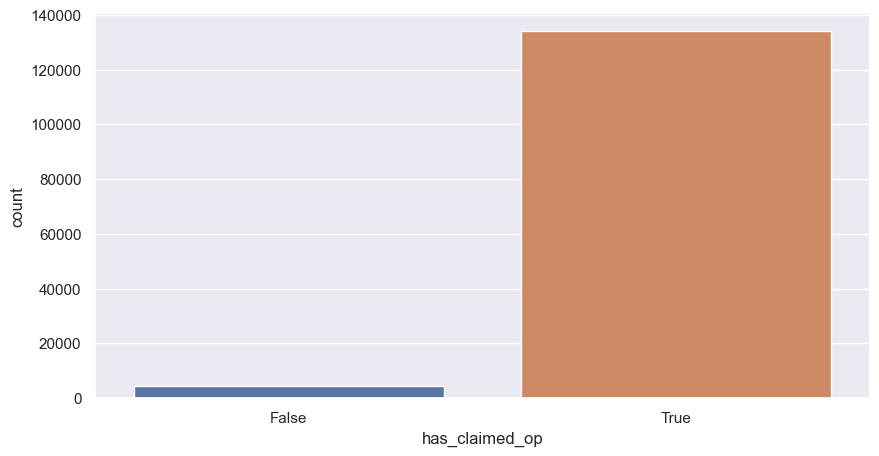

In [242]:
sns.countplot(x='has_claimed_op', data=df_bene)

**Merge beneficiaries with inpatient & outpatient data**

In [243]:
df_in = df_in.merge(df_bene, how='left', left_on='BeneID', right_on='BeneID')
df_out = df_out.merge(df_bene, how='left', left_on='BeneID', right_on='BeneID')

**One-Hot-Encoder**

In [244]:
# encoder = OneHotEncoder(handle_unknown='ignore')

In [245]:
# enc_df = pd.DataFrame(encoder.fit_transform(df_in[['Provider']]).toarray())

In [246]:
tmp = df_in.groupby(['Provider']).size()
tmp.name = 'Provcnt'

In [247]:
# df_all_new = pd.merge(df_all, tmp, left_on = 'Provider', right_index=True)

In [248]:
# bins = pd.cut(df_in.Provcnt, bins=2, labels=['low', 'high'])

<AxesSubplot:xlabel='Gender', ylabel='count'>

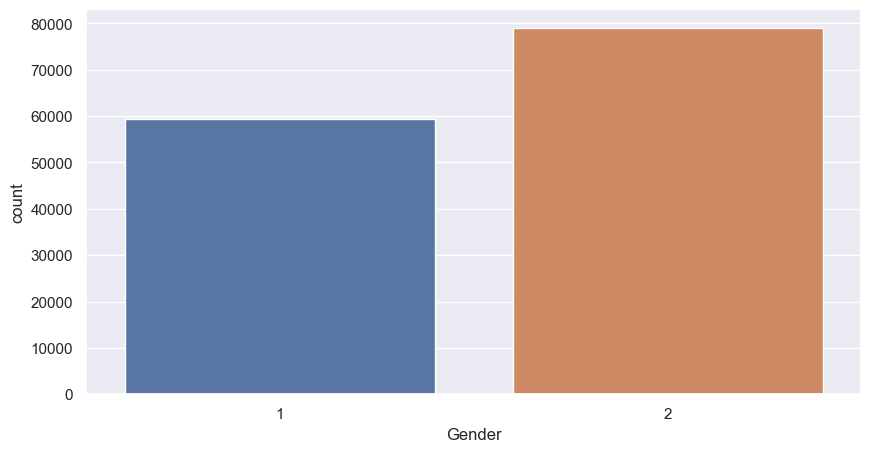

In [249]:
sns.countplot(x='Gender', data=df_bene)

# **Diseases**

**Alzheimers - inpatient**

In [250]:
df_in_bene_Alz = df_in[df_in['ChronicCond_Alzheimer'] == 1]

In [251]:
df_in_bene_Alz.PotentialFraud.value_counts()

Yes    11756
No      8645
Name: PotentialFraud, dtype: int64

<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

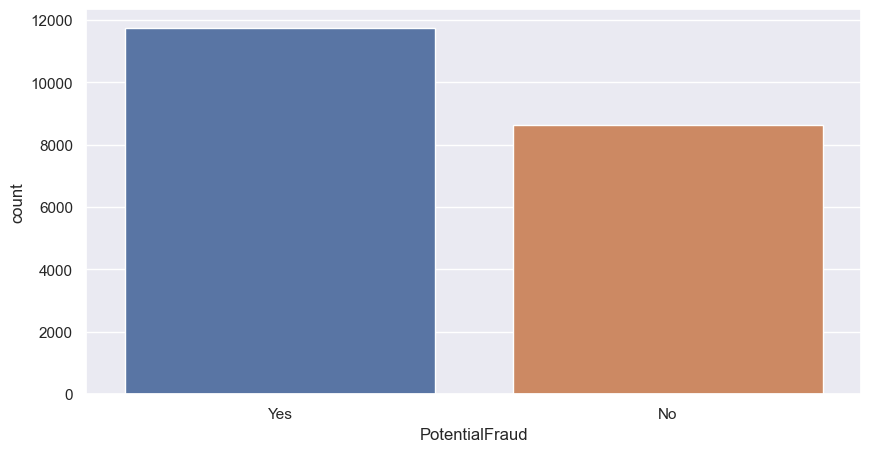

In [252]:
sns.countplot(x='PotentialFraud', data=df_in_bene_Alz)

**Alzheimers - outpatient**

In [253]:
df_out_bene_Alz = df_out[df_out['ChronicCond_Alzheimer'] == 1]

In [254]:
df_out_bene_Alz.PotentialFraud.value_counts()

No     129335
Yes     74591
Name: PotentialFraud, dtype: int64

In [255]:
# sns.countplot(x='PotentialFraud', data=df_out_bene_Alz)

# Exploratory Data Analysis

**Target Labels**

The target variable in the labelled dataset is "PotentialFraud" which indicates whether a provider is fradulent or not. Out of 5410 providers in total, 9.35% are fradulent.

<AxesSubplot:ylabel='PotentialFraud'>

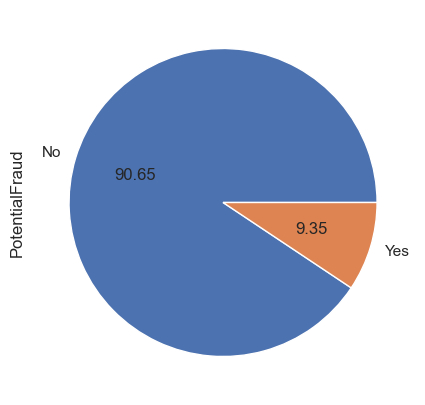

In [256]:
target = df_lab["PotentialFraud"]
target.value_counts().plot.pie(autopct='%.2f',figsize=(6, 5))

**Combine data frames**

In [257]:
df_all = pd.concat([df_in, df_out], ignore_index=True, sort=False)

**Convert datatype to Numeric**

In [258]:
# df_all_corr = df_all.loc[:, ['AttendingPhysician', 'OtherPhysician', 'OperatingPhysician'] ].corr()
# df_all_corr = round(df_all_corr.corr(), 2)

In [259]:
#sns.heatmap(df_all_corr, annot=True)

In [260]:
# df_all.loc[:, ['AttendingPhysician', 'OtherPhysician', 'OperatingPhysician']]

**Physician Fraud Analysis**

In [261]:
df_all_fraud = df_all[df_all.PotentialFraud == 'Yes']

In [262]:
df_all_fraud['AttendingPhysician'].replace(to_replace=['None'], value=np.nan, inplace=True)

/var/folders/tc/c8rjp8hn765724hng7xbcs5h0000gn/T/ipykernel_35675/2521671908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_fraud['AttendingPhysician'].replace(to_replace=['None'], value=np.nan, inplace=True)


In [263]:
df_all_fraud = df_all_fraud.groupby(['AttendingPhysician', 'Provider']).size().reset_index(name='counts')

In [264]:
# df_all_fraud['Provider'].apply('str')
# df_all_fraud['AttendingPhysician'].apply('str')

In [265]:
lower_qrt, middle_qrt, upper_qrt = df_all_fraud.counts.quantile([0.25,0.5,0.75])

In [266]:
conditions = [(df_all_fraud.counts <= lower_qrt),
              (df_all_fraud.counts > lower_qrt) & (df_all_fraud.counts <= middle_qrt),
              (df_all_fraud.counts > middle_qrt) & (df_all_fraud.counts <= upper_qrt),
              (df_all_fraud.counts > upper_qrt)
             ]

values = ['Normal' ,'Less suspicious', 'More suspicious', 'Fraud']

In [267]:
df_all_fraud['Physician_Potential_Fraud'] = np.select(conditions, values)

In [268]:
df_all_fraud

,AttendingPhysician,Provider,counts,Physician_Potential_Fraud
0,PHY311002,PRV57495,1,Normal
1,PHY311008,PRV51868,2,Less suspicious
2,PHY311011,PRV55689,17,Fraud
3,PHY311017,PRV52045,1,Normal
4,PHY311021,PRV56259,1,Normal
...,...,...,...,...
20799,PHY434128,PRV51149,1,Normal
20800,PHY434140,PRV54739,9,Fraud
20801,PHY434142,PRV54566,3,More suspicious
20802,PHY434153,PRV51951,1,Normal


In [269]:
df_all_fraud['Physician_Potential_Fraud'].value_counts()

Normal             8850
Fraud              4644
More suspicious    3710
Less suspicious    3600
Name: Physician_Potential_Fraud, dtype: int64

<AxesSubplot:ylabel='Physician_Potential_Fraud'>

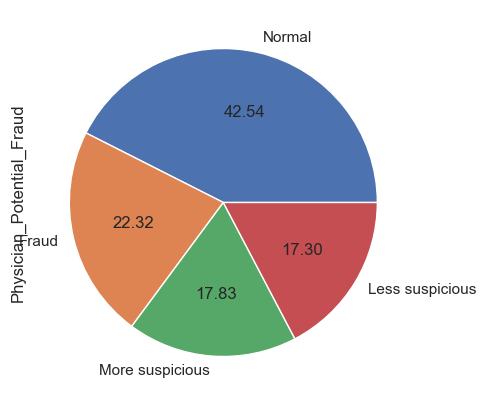

In [270]:
target = df_all_fraud['Physician_Potential_Fraud']
target.value_counts().plot.pie(autopct='%.2f',figsize=(6, 5))

In [271]:
df_all['Physician_Potential_Fraud'] = df_all_fraud['Physician_Potential_Fraud']

In [272]:
df_all['Physician_Potential_Fraud'].fillna("None", inplace=True) # why should this be done ?

In [273]:
df_all['Physician_Potential_Fraud']

0                  Normal
1         Less suspicious
2                   Fraud
3                  Normal
4                  Normal
               ...       
558206               None
558207               None
558208               None
558209               None
558210               None
Name: Physician_Potential_Fraud, Length: 558211, dtype: object

**Operating Physicial fraund analysis**

In [274]:
df_all_fraud = df_all[df_all.PotentialFraud == 'Yes']

In [275]:
df_all_fraud['OperatingPhysician'].replace(to_replace='None', value=np.nan, inplace=True)

/var/folders/tc/c8rjp8hn765724hng7xbcs5h0000gn/T/ipykernel_35675/2517755197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_fraud['OperatingPhysician'].replace(to_replace='None', value=np.nan, inplace=True)


In [276]:
df_all_fraud = df_all_fraud.groupby(['OperatingPhysician', 'Provider']).size().reset_index(name='counts')

In [277]:
conditions = [(df_all_fraud.counts <= lower_qrt),
              (df_all_fraud.counts > lower_qrt) & (df_all_fraud.counts <= middle_qrt),
              (df_all_fraud.counts > middle_qrt) & (df_all_fraud.counts <= upper_qrt),
              (df_all_fraud.counts > upper_qrt)
             ]

values = ['Normal' ,'Less suspicious', 'More suspicious', 'Fraud']

In [278]:
df_all_fraud['Operating_Physician_fraud'] = np.select(conditions, values)

In [279]:
df_all['Operating_Physician_fraud'] = df_all_fraud['Operating_Physician_fraud']

In [280]:
df_all['Operating_Physician_fraud'].fillna('None', inplace=True)

In [281]:
df_all['Operating_Physician_fraud']

0         More suspicious
1         Less suspicious
2                  Normal
3         Less suspicious
4                  Normal
               ...       
558206               None
558207               None
558208               None
558209               None
558210               None
Name: Operating_Physician_fraud, Length: 558211, dtype: object

# **Master dataframe**

In [282]:
df_master = pd.concat([df_in, df_out], ignore_index=True, sort=False)

In [407]:
df_master_ml = df_master.groupby('Provider').agg(
    Mean_InscClaimAmtReimbursed=('InscClaimAmtReimbursed', np.mean),
    Sum_InscClaimAmtReimbursed=('InscClaimAmtReimbursed', np.sum),
    Count_claims=('ClaimID', 'nunique'),
    Count_patients=('BeneID', 'nunique'),
    Count_attendingPhysician=('AttendingPhysician', 'nunique'),
    Count_operatingPhysican=('OperatingPhysician', 'nunique'),
    Mean_age=('Age',np.mean),
    Mean_hospitalduration=('hospital_duration', np.mean),
    Count_ClmDiagCode_1=('ClmDiagnosisCode_1', 'nunique'),
    Count_ClmDiagCode_2=('ClmDiagnosisCode_2', 'nunique'),
    Count_ClmProcCode_1=('ClmProcedureCode_1', 'nunique'),
    Count_ClmProcCode_2=('ClmProcedureCode_2', 'nunique'),
    label=('PotentialFraud', 'unique'),
)

In [413]:
df_master_ml = df_master_ml.explode('label')
df_master_ml.label = df_master_ml.label.replace(to_replace=['Yes', 'No'], value=[1,0])
df_master_ml

,Mean_InscClaimAmtReimbursed,Sum_InscClaimAmtReimbursed,Count_claims,Count_patients,Count_attendingPhysician,Count_operatingPhysican,Mean_age,Mean_hospitalduration,Count_ClmDiagCode_1,Count_ClmDiagCode_2,Count_ClmProcCode_1,Count_ClmProcCode_2,label
Provider,,,,,,,,,,,,,
PRV51001,4185.600000,104640,25,24,14,6,78.280000,1.000000,23,15,2,1,0
PRV51003,4588.409091,605670,132,117,44,8,69.553030,2.424242,115,86,32,7,1
PRV51004,350.134228,52170,149,138,38,20,71.812081,0.000000,128,68,0,0,0
PRV51005,241.124464,280910,1165,495,7,7,70.000858,0.000000,809,327,0,0,1
PRV51007,468.194444,33710,72,58,10,6,68.791667,0.222222,71,32,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57759,380.000000,10640,28,24,1,2,73.428571,0.000000,26,11,0,0,0
PRV57760,216.818182,4770,22,9,3,3,61.090909,0.000000,20,10,0,0,0
PRV57761,225.243902,18470,82,67,2,6,71.402439,0.000000,81,47,0,0,0


In [414]:
# df_master.loc[df_master.Provider == 'PRV51037']['ClmProcedureCode_1'].nunique()

In [410]:
df_master_ml_corr = round(df_master_ml.corr(), 1)

<AxesSubplot:>

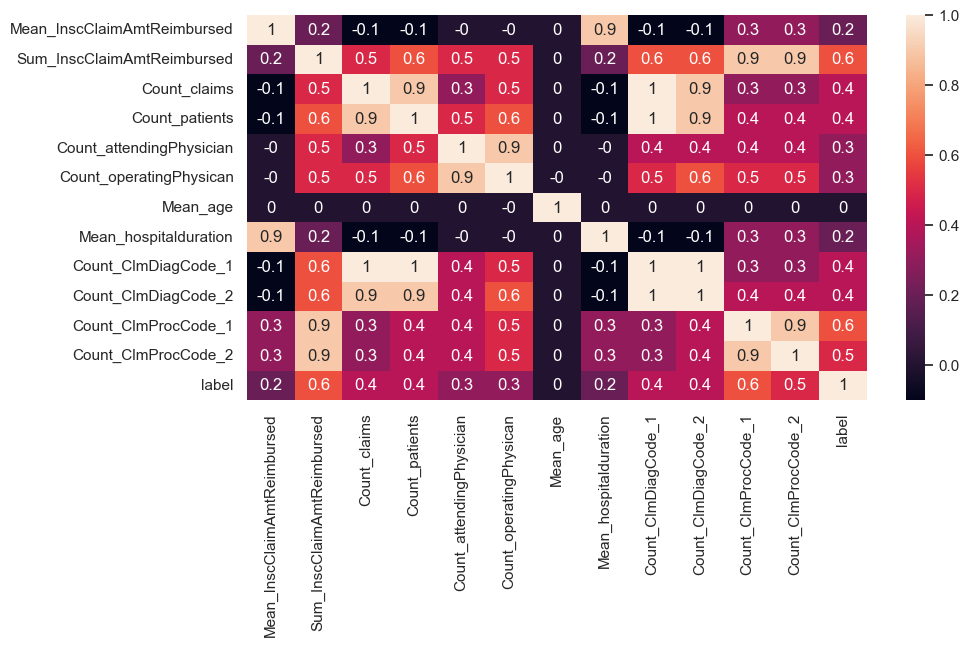

In [411]:
sns.heatmap(df_master_ml_corr, annot=True)

In [367]:
df_master_ml.dtypes

Mean_InscClaimAmtReimbursed    float64
Sum_InscClaimAmtReimbursed       int64
Count_claims                     int64
Count_patients                   int64
Count_attendingPhysician         int64
Count_operatingPhysican          int64
Mean_age                       float64
Mean_hospitalduration          float64
Count_ClmDiagCode_1              int64
Count_ClmDiagCode_2              int64
Count_ClmProcCode_1              int64
Count_ClmProcCode_2              int64
label                           object
dtype: object

# Modeling